**Use this notebook if data has missing annotations**

# Importing libraries

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF
import tensorflow as tf
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
!pip install pytictoc

In [3]:
!pip install kneed

In [4]:
from pytictoc import TicToc
t = TicToc()

# Importing scRNA-seq data

In [5]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
ls "/content/drive/My Drive/scRNASeq_RKM_data/EBI_normalized/"

E-GEOD-130148_Labels.csv  E-GEOD-81547_Labels.csv  ExpDesign-E-GEOD-130148.csv
E-GEOD-130148.norm.csv    E-GEOD-81547.norm.csv    ExpDesign-E-GEOD-81547.csv


In [7]:
data = pd.read_csv("/content/drive/My Drive/scRNASeq_RKM_data/EBI_normalized/E-GEOD-81547.norm.csv", header=0, index_col=None, sep=",")

In [8]:
labels = pd.read_csv("/content/drive/My Drive/scRNASeq_RKM_data/EBI_normalized/E-GEOD-81547_Labels.csv", header=0, index_col=None, sep=",")

In [9]:
data = data.T

In [10]:
data.reset_index(inplace=True, drop=True)

In [11]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,27788,27789,27790,27791,27792,27793,27794,27795,27796,27797,27798,27799,27800,27801,27802,27803,27804,27805,27806,27807,27808,27809,27810,27811,27812,27813,27814,27815,27816,27817,27818,27819,27820,27821,27822,27823,27824,27825,27826,27827
0,1.930023,0.00000,3.07583,9.751206,0.0,0.0,403.339020,0.000000,0.00000,2.904284,0.000000,0.0,2.850452,0.0,0.0,1.202331,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,51.308144,1.425721,0.0,0.0,0.000000,0.0,19.953167,0.0,74.11176,8.551357,0.0,0.0,284.985230,0.0,0.000000,1.425226,89.684240,44.717598,...,0.0,0.0,14.252262,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,21.378393,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.000000,193.19691,743.46606,8.586529,0.0,0.0,427.895400,0.000000,0.00000,5.802120,0.000000,0.0,0.000000,0.0,0.0,0.000000,85.865295,6.226224,1.431088,0.0,0.000000,0.000000,326.288120,0.000000,0.0,0.0,2.862176,0.0,0.000000,0.0,62.96788,0.000000,0.0,0.0,177.454940,0.0,7.155441,9.179057,62.734364,73.040910,...,0.0,0.0,9.925777,0.0,0.0,0.0,367.2975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,4.293264,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.102823
2,223.590700,0.00000,0.00000,0.000000,0.0,0.0,112.955670,3.425877,147.18466,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,632.594700,0.000000,0.000000,0.0,0.000000,17.114496,51.343490,4.084169,0.0,0.0,3.422899,0.0,35.548943,0.0,0.00000,0.000000,0.0,0.0,3.422899,0.0,0.000000,0.000000,604.646850,47.678932,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,82.045840,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,25.825342,0.00000,0.00000,2.335857,0.0,0.0,802.719700,0.000000,303.84277,2.103501,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,26.688890,0.000000,0.0,6.158975,2.052992,521.459900,0.000000,0.0,0.0,0.000000,0.0,5.638093,0.0,82.11967,67.748726,0.0,0.0,1.396098,0.0,0.000000,0.000000,717.835940,561.994700,...,0.0,0.0,50.371273,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.423933,117.020520,0.0,0.0,0.0,0.0,32.93281,0.0,4.105983,0.0,16.423933,55.812305,0.0,0.0,8.526393,4.105983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.868786
4,0.000000,0.00000,0.00000,0.000000,0.0,0.0,3.699278,0.000000,0.00000,9.465551,9.248196,0.0,1057.993500,0.0,0.0,0.000000,453.161560,0.000000,11.097835,0.0,0.000000,127.625090,72.135925,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,173.866070,0.0,0.000000,0.000000,42.694040,12.273494,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.737366,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000,3.727849,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


# Scaling data (if required)

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data))
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,27788,27789,27790,27791,27792,27793,27794,27795,27796,27797,27798,27799,27800,27801,27802,27803,27804,27805,27806,27807,27808,27809,27810,27811,27812,27813,27814,27815,27816,27817,27818,27819,27820,27821,27822,27823,27824,27825,27826,27827
0,0.000971,0.00000,0.003468,0.013900,0.0,0.0,0.166623,0.000000,0.000000,0.002740,0.000000,0.0,0.001793,0.0,0.0,0.000922,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.008591,0.001607,0.0,0.0,0.000000,0.0,0.013599,0.0,0.027803,0.004942,0.0,0.0,0.147579,0.0,0.000000,0.001806,0.032543,0.012211,...,0.0,0.0,0.118530,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.080571,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.000000,0.08763,0.838377,0.012239,0.0,0.0,0.176767,0.000000,0.000000,0.005473,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.030998,0.00652,0.001873,0.0,0.000000,0.000000,0.054630,0.000000,0.0,0.0,0.048498,0.0,0.000000,0.0,0.023622,0.000000,0.0,0.0,0.091895,0.0,0.003836,0.011629,0.022764,0.019946,...,0.0,0.0,0.082548,0.0,0.0,0.0,0.322538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.016180,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012162
2,0.112468,0.00000,0.000000,0.000000,0.0,0.0,0.046663,0.001817,0.068784,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.228369,0.00000,0.000000,0.0,0.000000,0.011749,0.008596,0.004603,0.0,0.0,0.058000,0.0,0.024228,0.0,0.000000,0.000000,0.0,0.0,0.001773,0.0,0.000000,0.000000,0.219403,0.013020,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.309214,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.012990,0.00000,0.000000,0.003330,0.0,0.0,0.331611,0.000000,0.141995,0.001984,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.02795,0.000000,0.0,0.007678,0.001409,0.087308,0.000000,0.0,0.0,0.000000,0.0,0.003843,0.0,0.030807,0.039152,0.0,0.0,0.000723,0.0,0.000000,0.000000,0.260474,0.153469,...,0.0,0.0,0.418917,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.073742,0.441027,0.0,0.0,0.0,0.0,0.164968,0.0,0.019823,0.0,0.02052,0.040561,0.0,0.0,0.091327,0.026901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.087103
4,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.001528,0.000000,0.000000,0.008929,0.006334,0.0,0.665536,0.0,0.0,0.000000,0.163593,0.00000,0.014526,0.0,0.000000,0.087610,0.012078,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.090036,0.0,0.000000,0.000000,0.015492,0.003352,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.290664,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.002709,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


# Checking loaded data

In [13]:
data.shape

(2544, 27828)

In [14]:
labels.shape

(2544, 3)

In [15]:
labels.nunique()

Assay      2544
Labels        6
Labels1       6
dtype: int64

In [16]:
labels = labels['Labels1']
labels.head()

0    Pancreatic A Cell
1    Pancreatic A Cell
2          Acinar Cell
3    Pancreatic A Cell
4    Pancreatic A Cell
Name: Labels1, dtype: object

# Finding the optimal dimensions for embedding using reconstruction error

In [17]:
d = range(2,16)
k=[]
error=[]
# try each value of k
for i in d:
    print("Applying NMF for k=%d ..." % i)
    # run NMF
    model = NMF(init="nndsvd", n_components=i) 
    W = model.fit_transform(data)
    H = model.components_    
    k.append(i)
    error.append(model.reconstruction_err_)

Applying NMF for k=2 ...
Applying NMF for k=3 ...
Applying NMF for k=4 ...
Applying NMF for k=5 ...
Applying NMF for k=6 ...
Applying NMF for k=7 ...
Applying NMF for k=8 ...
Applying NMF for k=9 ...
Applying NMF for k=10 ...
Applying NMF for k=11 ...
Applying NMF for k=12 ...
Applying NMF for k=13 ...
Applying NMF for k=14 ...
Applying NMF for k=15 ...


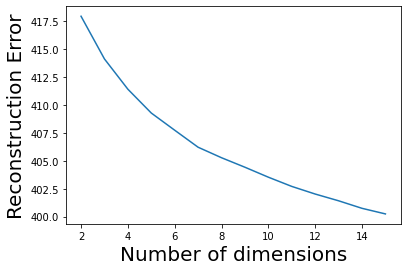

In [18]:
# Plotting a bar graph to compare the results 
plt.plot(k, error) 
plt.xlabel('Number of dimensions', fontsize = 20) 
plt.ylabel('Reconstruction Error', fontsize = 20) 
plt.show() 

In [19]:
x = range(2, len(error)+2)

from kneed import KneeLocator
kn = KneeLocator(x, error, curve='convex', direction='decreasing')
print(kn.knee)

7


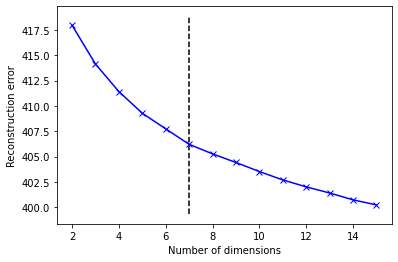

In [20]:
plt.xlabel('Number of dimensions')
plt.ylabel('Reconstruction error')
plt.plot(x, error, 'bx-')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

# Lower dimensional cell embedding using NMF

In [21]:
optDim = kn.knee

In [22]:
#Mark the begining of the proposed method
t.tic()

In [23]:
data_orig = data.copy()

In [24]:
model = NMF(n_components=optDim, init='nndsvd')
W = model.fit_transform(data)
H = model.components_

In [25]:
print(W.shape)
print(H.shape)

(2544, 7)
(7, 27828)


In [26]:
data = pd.DataFrame(W)

# (A) Encoding labels (B) Labelling unknown cells as -1

In [27]:
print('Count of missing labels = ', sum(pd.isna(labels)))
print('Percentage of missing labels = {0:.2f}'.format(sum(pd.isna(labels)/len(labels)*100)))

Count of missing labels =  262
Percentage of missing labels = 10.30


In [28]:
index = labels.loc[pd.isna(labels)].index

**Encoding the labels**

In [29]:
labels = labels.fillna('Unknown')

In [30]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y = pd.DataFrame(le.fit_transform(np.ravel(labels)))

In [31]:
y1 = y[0].copy()

In [32]:
lab_dict = dict(zip(y[0], labels))

**Labelling unknown data as -1**

In [33]:
dataWOmissingLab = data_orig.iloc[~y.index.isin(index)]
LabNOTmissing = y.iloc[~y.index.isin(index)]

In [34]:
y.iloc[index] = -1           # setting Unknown labels as -1
indx = pd.DataFrame(np.arange(0,data.shape[0]))
df = pd.concat([data,indx], axis=1)
X = pd.concat([df,y], axis=1)

In [35]:
#Setting k to the number of unique labels in the data excluding -1 (-1 stands for unknown labels)
k = y[0].nunique()-1

# Clustering using k-Means

Recursive clustering

In [36]:
def rec_KMeans(res):
    if len(res) == 0:
        return
    
    num_labels = set()
    #finding no. of known labels for each cluster
    for i in res:
        if(i[-1] != -1):
          num_labels.add(i[-1])
    print(len(num_labels), num_labels)   

    if(len(num_labels) == 1):     #if all labelled data belong from one class
        final_clusters.append(res)
        cluster_label.append(num_labels)
        return
    
    if(len(num_labels) == 0):     #if no labelled data exist
        final_clusters.append(res)
        cluster_label.append(-1)
        return
    
    #if all labelled data belong from more than one class, then cluster recursively
    newk = len(num_labels)
    centroid1 = []
    rnd = random.sample(range(len(res)), newk)
    for j in range(newk):
        centroid1.append(res[rnd[j]])
        
    print('Partioning further...')
    my_KMeans(res, centroid1, newk)

Passing each partition to recursive k-Means function

In [37]:
def rec_KMeans_call(res):
    for par in res:
        print('...New cluster...')   
        rec_KMeans(res[par])

Distance between a given sample and a given centroid

In [38]:
def distance(a,b):
    ans = 0
    for i in range(len(a)):
        ans += math.pow((a[i] - b[i]),2)
    return math.sqrt(ans)

In [39]:
def my_KMeans(data, centroid, k):  #using user-defined KMeans
    
    #max_iter = 1
    #for i in range(max_iter):
        
    diction = {}    #empty dictionary to store data corresponding to each cluster
    for i in range(k):
        diction[i]=[]
        
    for j in range(len(data)):
        l = []
        for c in centroid:
            l.append(distance(data[j][:-2],c[:-2]))      #calculate distance of the sample from each centroid
        diction[l.index(min(l))].append(data[j])         #assigning the sample to the nearest centroid
    
    for c in diction:     #update centroids
        if(len(diction[c])!=0):
            centroid[c] = np.average(diction[c], axis = 0)
    rec_KMeans_call(diction)

In [40]:
cntr = []
final_clusters = []
cluster_label = []

In [41]:
#Initializing centroids
random.seed(0)
rnd = random.sample(range(X.shape[0]), k)
for i in range(k):
        cntr.append(X.iloc[rnd[i]])

In [42]:
#initial k-Means call  
my_KMeans(X.values, cntr, k)

...New cluster...
6 {0.0, 1.0, 2.0, 3.0, 4.0, 5.0}
Partioning further...
...New cluster...
1 {4.0}
...New cluster...
2 {0.0, 4.0}
Partioning further...
...New cluster...
2 {0.0, 4.0}
Partioning further...
...New cluster...
2 {0.0, 4.0}
Partioning further...
...New cluster...
2 {0.0, 4.0}
Partioning further...
...New cluster...
2 {0.0, 4.0}
Partioning further...
...New cluster...
2 {0.0, 4.0}
Partioning further...
...New cluster...
1 {0.0}
...New cluster...
1 {4.0}
...New cluster...
1 {4.0}
...New cluster...
2 {0.0, 4.0}
Partioning further...
...New cluster...
2 {0.0, 4.0}
Partioning further...
...New cluster...
0 set()
...New cluster...
2 {0.0, 4.0}
Partioning further...
...New cluster...
1 {0.0}
...New cluster...
1 {4.0}
...New cluster...
0 set()
...New cluster...
1 {4.0}
...New cluster...
1 {4.0}
...New cluster...
1 {4.0}
...New cluster...
3 {0.0, 1.0, 4.0}
Partioning further...
...New cluster...
2 {1.0, 4.0}
Partioning further...
...New cluster...
2 {1.0, 4.0}
Partioning further...


# Results

Computing final centroids

In [43]:
def get_final_centroids(final_clusters):
    final_centroids = []
    for i in range(len(final_clusters)):
        fc = pd.DataFrame(final_clusters[i]).iloc[:, :-2]
        fc_mean = np.average(fc,axis = 0)
        final_centroids.append(fc_mean)
    return final_centroids


In [44]:
final_centroids = get_final_centroids(final_clusters)

In [45]:
def get_final_results(cluster_label):
    no_of_points = []
    labelled = []
    unlabelled = []
    cluster_lbl = []

    dtf = [f'cluster{i}' for i in range(1,len(final_clusters) + 1)]
    results = pd.DataFrame(dtf, columns = ['Clusters'])
    
    for i in cluster_label:
        if( i != -1):
            cluster_lbl.append(int(list(i)[0]))
        else:
            cluster_lbl.append(i)
        
    results['Label'] = cluster_lbl
    
    for i in range(len(final_clusters)):
        no_of_points.append(len(final_clusters[i]))  #count of total samples
        cl = 0
        cu = 0
        for j in final_clusters[i]:
            if(j[-1] == -1):
                cu += 1       #count of unlabelled samples
            else:
                cl += 1       #count of labelled samples
        labelled.append(cl)
        unlabelled.append(cu)

    results['Total_Count'] = no_of_points
    results['Count_ld'] = labelled
    results['Count_ud'] = unlabelled
    return results

In [46]:
result = get_final_results(cluster_label)
print(result)

       Clusters  Label  Total_Count  Count_ld  Count_ud
0      cluster1      4          137       134         3
1      cluster2      0            1         1         0
2      cluster3      4            1         1         0
3      cluster4      4            4         3         1
4      cluster5     -1            2         0         2
..          ...    ...          ...       ...       ...
595  cluster596      3            1         1         0
596  cluster597      5            1         1         0
597  cluster598      5            2         2         0
598  cluster599      5            2         2         0
599  cluster600      5            3         3         0

[600 rows x 5 columns]


# Labelling clusters with both labelled and unlabelled cells

In [47]:
pl=[]
index=[]

for i in range(len(result)):
    cls = result['Label'][i]
    nud = result['Count_ud'][i]
    if cls != -1 and nud > 0:
        for j in final_clusters[i]:
            if(j[-1] == -1):
                j[-1] = cls   #setting the class label
                #marking the predicted label and corresponding index position
                id = int(j[-2])
                index.append(id)     
                pl.append(cls)

# Setting weighted radius of clusters as threshold

In [48]:
rad=[]
for i in range(len(final_centroids)):
    dist=[]
    for j in final_clusters[i]:
        dist.append(distance(final_centroids[i],j[:-2]))
    rad.append(np.max(dist))

In [49]:
wrad=0
npnts=data.shape[0]
for i in range(len(final_clusters)):
    wrad += rad[i]*len(final_clusters[i])
wrad/=npnts

# Labelling the clusters with all unlabelled cells

In [50]:
pos = [i for i in result.loc[result['Label']==-1].index]

In [51]:
d = euclidean_distances(final_centroids, final_centroids)
for i in pos:
    nc = i
    #find nearest labelled cluster
    while result.loc[nc,'Label'] == -1:
        d[i][nc]=999
        nn = np.where(d[i] == np.amin(d[i]))  #finding nearest neighbor of the unlabelled cluster
        nc = nn[0][0]

    #Setting labels of unlabelled data in unlabelled clusters to the class label of the nearest cluster
    #if distance from nearest centroid is less than or equal to threshold distance (weighted radius)
    l = len(final_clusters[i])  #number of points in cluster i
    print('no. of points in cluster {0}: {1}'.format(i,l))
    c=0
    for j in final_clusters[i]:
        if (distance(final_centroids[nc],j[:-2]) <= wrad):
            c+=1
            j[-1] = result['Label'][nc]   #setting the class label
            #marking the predicted label
            id = int(j[-2])
            index.append(id)
            pl.append(int(j[-1]))
    print('no. of points labelled now: ',c)
    if c==l:    #implies labels of all samples in cluster i changed
        print('Label of cluster {0} changed to the label of its nearest neighbour cluster {1}'.format(i+1,nc))
        result.loc[i,'Label'] = result.loc[nc,'Label']

no. of points in cluster 4: 2
no. of points labelled now:  2
Label of cluster 5 changed to the label of its nearest neighbour cluster 6
no. of points in cluster 7: 2
no. of points labelled now:  2
Label of cluster 8 changed to the label of its nearest neighbour cluster 4
no. of points in cluster 13: 2
no. of points labelled now:  1
no. of points in cluster 59: 2
no. of points labelled now:  0
no. of points in cluster 81: 3
no. of points labelled now:  3
Label of cluster 82 changed to the label of its nearest neighbour cluster 94
no. of points in cluster 132: 1
no. of points labelled now:  1
Label of cluster 133 changed to the label of its nearest neighbour cluster 202
no. of points in cluster 174: 1
no. of points labelled now:  1
Label of cluster 175 changed to the label of its nearest neighbour cluster 175
no. of points in cluster 224: 1
no. of points labelled now:  1
Label of cluster 225 changed to the label of its nearest neighbour cluster 222
no. of points in cluster 266: 9
no. of 

Computing running time

In [52]:
#Compute time elapsed at the end of proposed algorithm
t.toc()

Elapsed time is 66.921820 seconds.


# Results after reassignment

In [53]:
def get_final_results(result):
    labelled = []
    unlabelled = []
    for i in range(len(final_clusters)):
        cl = 0
        cu = 0
        for j in final_clusters[i]:
            if(j[-1] == -1):
                cu += 1       #count of unlabelled samples
            else:
                cl += 1       #count of labelled samples
        labelled.append(cl)
        unlabelled.append(cu)

    result['Count_ld_Now'] = labelled
    result['Count_ud_Now'] = unlabelled
    return result

In [54]:
reassignmentResult = get_final_results(result)
print(reassignmentResult)

       Clusters  Label  Total_Count  ...  Count_ud  Count_ld_Now  Count_ud_Now
0      cluster1      4          137  ...         3           137             0
1      cluster2      0            1  ...         0             1             0
2      cluster3      4            1  ...         0             1             0
3      cluster4      4            4  ...         1             4             0
4      cluster5      4            2  ...         2             2             0
..          ...    ...          ...  ...       ...           ...           ...
595  cluster596      3            1  ...         0             1             0
596  cluster597      5            1  ...         0             1             0
597  cluster598      5            2  ...         0             2             0
598  cluster599      5            2  ...         0             2             0
599  cluster600      5            3  ...         0             3             0

[600 rows x 7 columns]


In [55]:
#Finding how many samples are still unlabelled
count = 0
unlab = []
for i in range(len(final_clusters)):
  for j in final_clusters[i]:
    if(j[-1] == -1):
      count+=1
      unlab.append(int(j[-2]))
print('Count of unlabelled cells: ', count)
print('Percentage of unlabelled cells: {0:.2f}'.format(count/data.shape[0]*100))
if count>0:
  print('Unknown cell indices: ',unlab)

Count of unlabelled cells:  7
Percentage of unlabelled cells: 0.28
Unknown cell indices:  [1292, 1377, 1389, 98, 1262, 1436, 1429]


In [61]:
#Remove unpredicted cells from data
index_labelled = ~data_orig.index.isin(unlab)
data_labelled = data_orig.iloc[~data_orig.index.isin(unlab)]

In [62]:
labWOmissing = pd.DataFrame(list(zip(LabNOTmissing.index,LabNOTmissing[0].values)), columns = ['Index', 'Predicted Label'])

In [63]:
predicted = pd.DataFrame(list(zip(index, pl)), columns = ['Index', 'Predicted Label'])

In [64]:
allLabels = pd.concat([labWOmissing, predicted], axis=0).sort_values(by = 'Index')

**Cohesion and separation of clusters with newly predicted predicted cells added**

In [66]:
#for data with newly predicted cells added
print('Internal indices for data including newly predicted cells (After Clustering):  \n')
print('Calinski Harabasz Score: {0:.2f}'.format(calinski_harabasz_score(data_labelled, allLabels['Predicted Label'].values)))

Internal indices for data including newly predicted cells (After Clustering):  

Calinski Harabasz Score: 21.30


# -----------THE END----------